<a href="https://colab.research.google.com/github/youngmantis/Computional-Drug-Discovery/blob/main/TNAP_Regression_Models_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Install required packages
!pip install -q seaborn

In [ ]:
# Load necessary TensorFlow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


In [ ]:
# Load bioactivity data
df = pd.read_csv('/content/Alkaline phosphatase tissue non specific_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Columns: 882 entries, PubchemFP0 to pIC50
dtypes: float64(1), int64(881)
memory usage: 17.4 MB


In [ ]:
# Split the dataset into training and testing sets
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)

train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_df.pop('pIC50')
test_labels = test_df.pop('pIC50')

In [ ]:
pip install tensorflow-determinism

In [ ]:
import random
import os
from sklearn.preprocessing import StandardScaler

def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(42)

In [ ]:
# Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[0.996 0.961 0.611 0.089 0.    0.    0.018 0.    0.    1.    1.    0.984
  0.691 0.039 0.942 0.815 0.437 0.021 0.949 0.829 0.394 0.075 0.004 0.25
  0.127 0.021 0.    0.    0.001 0.    0.081 0.035 0.002 0.409 0.085 0.004
  0.    0.334 0.141 0.009 0.    0.    0.    0.029 0.001 0.    0.003 0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.013 0.013 0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.013 0.006 0.006
  0.007 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.741
  0.055 0.598 0.641 0.019 0.073 0.074 0.306 0.001 0.169 0.285 0.    0.001
  0.001 0.085 0.    0.038 0.059 0.    0.    0.    0.009 0.  

In [ ]:
# Linear model
linear_model_v1 = tf.keras.Sequential([
    layers.Dense(units=1)
])

linear_model_v1.compile(
    optimizer='adam',  # Default optimizer (Adam) with default learning rate
    loss='mean_absolute_error'  # Default loss function (Mean Absolute Error)
)

history_v1 = linear_model_v1.fit(
    train_features,
    train_labels,
    epochs=10,  # Default number of epochs
    validation_split=0.2,
    verbose=0
)

In [ ]:
print("Model parameters:")
print("Weight:", linear_model_v1.layers[0].get_weights()[0][0][0])  # Slope
print("Bias:", linear_model_v1.layers[0].get_weights()[1][0])        # Intercept

Model parameters:
Weight: 0.13481106
Bias: 0.079718396


In [ ]:
# Adjusted linear model
linear_model_v2 = tf.keras.Sequential([
    layers.Dense(units=1)
])

# Compile adjusted linear model
linear_model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanAbsoluteError()
)

# Fit the model
history_v2 = linear_model_v2.fit(
    train_features,
    train_labels,
    epochs=1000,  # Increased epochs for better convergence
    validation_split=0.2,
    verbose=0
)

In [ ]:
print("Model parameters:")
print("Weight:", linear_model_v2.layers[0].get_weights()[0][0][0])  # Slope
print("Bias:", linear_model_v2.layers[0].get_weights()[1][0])        # Intercept

Model parameters:
Weight: -0.00059752195
Bias: 0.0024493202


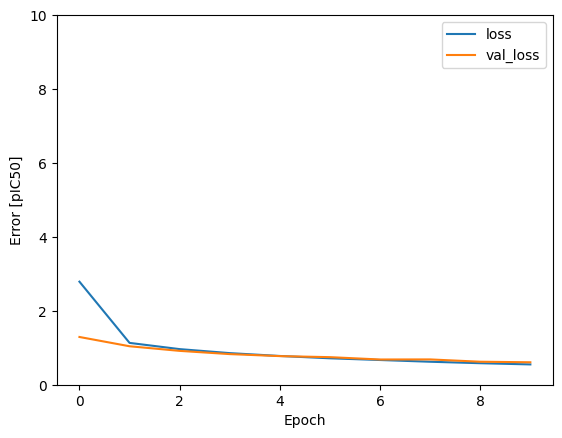

In [ ]:
# Plot loss for scaled linear regression model
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [pIC50]')
    plt.legend()
    plt.grid(False)

    # Save the plot as a PDF file
plt.savefig('loss_plot_linear_regression_v1.pdf')

plot_loss(history_v1)

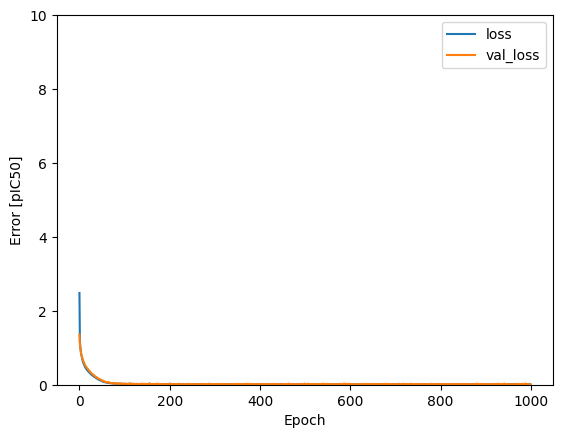

In [ ]:
# Plot loss for adjusted learning rate linear regression model

# Save the plot as a PDF file
plt.savefig('loss_plot_linear_regression_v2.pdf')

plot_loss(history_v2)

In [ ]:
# Evaluate linear model on test set
test_results = {}

# Linear Regression with Feature Scaling
test_results['linear_model_v1'] = linear_model_v1.evaluate(test_features, test_labels, verbose=0)

# Linear Regression with Adjusted Learning Rate
test_results['linear_model_v2'] = linear_model_v2.evaluate(test_features, test_labels, verbose=0)

# Display test results
pd.DataFrame(test_results, index=['Mean absolute error [pIC50]']).T

,Mean absolute error [pIC50]
linear_model_v1,0.566859
linear_model_v2,0.009062


In [ ]:
# Deep Neural Network (DNN) with default architecture and parameters
def build_and_compile_model_v1(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam()
    )
    return model

dnn_model_v1 = build_and_compile_model_v1(normalizer)
history_v1 = dnn_model_v1.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=10
)

In [ ]:
# Deep Neural Network (DNN) with modified architecture
def build_and_compile_model_v2(norm):
    model = keras.Sequential([
        norm,
        #layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(0.012)
    )
    return model

dnn_model_v2 = build_and_compile_model_v2(normalizer)
history_v2 = dnn_model_v2.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=1000
)

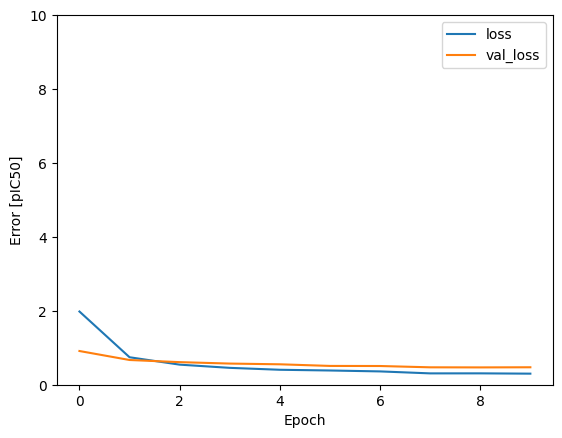

In [ ]:
# Plot loss for DNN v1 model
plt.grid(False)

# Save the plot as a PDF file
plt.savefig('loss_plot_dnn_v1.pdf')

plot_loss(history_v1)

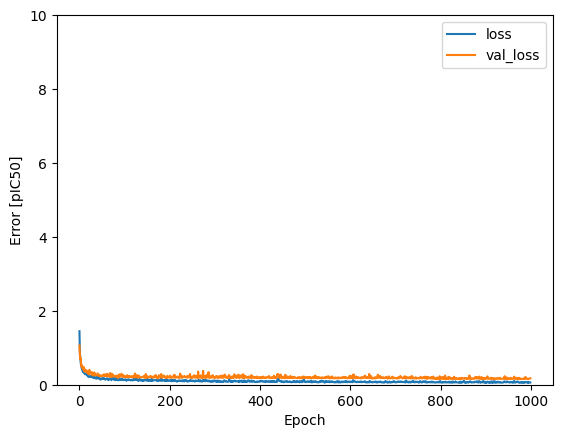

In [ ]:
# Plot loss for DNN v2 model
plt.grid(False)

# Save the plot as a PDF file
plt.savefig('loss_plot_dnn_v2.pdf')

plot_loss(history_v2)

In [ ]:
# Evaluate DNN with default architecture
test_results['dnn_model_v1'] = dnn_model_v1.evaluate(test_features, test_labels, verbose=0)

# Evaluate DNN with modified architecture
test_results['dnn_model_v2'] = dnn_model_v2.evaluate(test_features, test_labels, verbose=0)

# Display test results
pd.DataFrame(test_results, index=['Mean absolute error [pIC50]']).T

,Mean absolute error [pIC50]
linear_model_v1,0.566859
linear_model_v2,0.009062
dnn_model_v1,11873.918945
dnn_model_v2,0.161688


In [ ]:
# Save linear model for future use
linear_model_v1.save('linear_model_v1.keras')
linear_model_v2.save('linear_model_v2.keras')

In [ ]:
# Save DNN model for future use
dnn_model_v1.save('dnn_model_v1.keras')
dnn_model_v2.save('dnn_model_v1.keras')

In [ ]:
# Evaluation metrics for all models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

linear_model_v1_predictions = linear_model_v1.predict(test_features).flatten()
linear_model_v2_predictions = linear_model_v2.predict(test_features).flatten()
dnn_model_v1_predictions = dnn_model_v1.predict(test_features).flatten()
dnn_model_v2_predictions = dnn_model_v2.predict(test_features).flatten()
#dnn_model_v3_predictions = dnn_model_v3.predict(train_features_normalized).flatten()
#dnn_model_bn_predictions = dnn_model_bn.predict(train_features_normalized).flatten()
#dnn_model_dropout_predictions = dnn_model_dropout.predict(train_features_normalized).flatten()
#dnn_model_bn_dropout_predictions = dnn_model_bn_dropout.predict(train_features_normalized).flatten()

results = {
    'MAE': [
        mean_absolute_error(test_labels, linear_model_v1_predictions),
        mean_absolute_error(test_labels, linear_model_v2_predictions),
        mean_absolute_error(test_labels, dnn_model_v1_predictions),
        mean_absolute_error(test_labels, dnn_model_v2_predictions),
        #mean_absolute_error(test_labels, dnn_model_bn_predictions),
        #mean_absolute_error(test_labels, dnn_model_dropout_predictions),
        #mean_absolute_error(test_labels, dnn_model_v3_predictions),
        #mean_absolute_error(test_labels, dnn_model_bn_dropout_predictions)
    ],
    'MSE': [
        mean_squared_error(test_labels, linear_model_v1_predictions),
        mean_squared_error(test_labels, linear_model_v2_predictions),
        mean_squared_error(test_labels, dnn_model_v1_predictions),
        mean_squared_error(test_labels, dnn_model_v2_predictions),
        #mean_squared_error(test_labels, dnn_model_bn_predictions),
        #mean_squared_error(test_labels, dnn_model_dropout_predictions),
        #mean_squared_error(test_labels, dnn_model_v3_predictions),
        #mean_squared_error(test_labels, dnn_model_bn_dropout_predictions)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(test_labels, linear_model_v1_predictions)),
        np.sqrt(mean_squared_error(test_labels, linear_model_v2_predictions)),
        np.sqrt(mean_squared_error(test_labels, dnn_model_v1_predictions)),
        np.sqrt(mean_squared_error(test_labels, dnn_model_v2_predictions)),
        #np.sqrt(mean_squared_error(test_labels, dnn_model_bn_predictions)),
        #np.sqrt(mean_squared_error(test_labels, dnn_model_dropout_predictions)),
        #np.sqrt(mean_squared_error(test_labels, dnn_model_v3_predictions)),
        #np.sqrt(mean_squared_error(test_labels, dnn_model_bn_dropout_predictions))
    ],
    'R-squared': [
        r2_score(test_labels, linear_model_v1_predictions),
        r2_score(test_labels, linear_model_v2_predictions),
        r2_score(test_labels, dnn_model_v1_predictions),
        r2_score(test_labels, dnn_model_v2_predictions),
        #r2_score(test_labels, dnn_model_bn_predictions),
       #r2_score(test_labels, dnn_model_dropout_predictions),
        #r2_score(test_labels, dnn_model_v3_predictions),
        #r2_score(test_labels, dnn_model_bn_dropout_predictions)
    ]
}

results_df = pd.DataFrame(results, index=[
    'linear_model_v1',
    'linear_model_v2',
    'dnn_model_v1',
    'dnn_model_v2',
    #'dnn_model_v3',
    #'dnn_model_bn',
    #'dnn_model_dropout',
    #'dnn_model_bn_dropout'
])

results_df

17/17 [==============================] - 0s 2ms/step


,MAE,MSE,RMSE,R-squared
linear_model_v1,0.566859,5.676803e-01,0.753446,7.455146e-01
linear_model_v2,0.009062,1.945113e-04,0.013947,9.999128e-01
dnn_model_v1,11873.919251,1.962097e+10,140074.888814,-8.795886e+09
dnn_model_v2,0.161688,1.295442e-01,0.359922,9.419266e-01


In [ ]:
# Convert DataFrame to LaTeX string
latex = results_df.to_latex(index=False)

# Generate PDF using matplotlib
plt.figure(figsize=(8, 6))
plt.axis('off')  # Hide axis
plt.table(cellText=results_df.values,
          colLabels=results_df.columns,
          loc='center')
plt.savefig('results.pdf', bbox_inches='tight', pad_inches=0.1)
plt.close()

In [ ]:
# Save as CSV
results_df.to_csv('results.csv', index=False)

# Save as Excel
results_df.to_excel('results.xlsx', index=False)

17/17 [==============================] - 0s 2ms/step


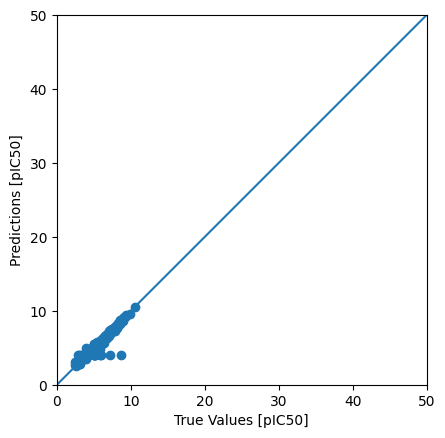

In [ ]:
# Make predictions with the best DNN model on the test set
test_predictions_dnn = dnn_model_v2.predict(test_features).flatten()

# Scatter plot for DNN model predictions
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_dnn)
plt.xlabel('True Values [pIC50]')
plt.ylabel('Predictions [pIC50]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save the plot as a PDF file
plt.savefig('plot_of_best_dnn_model.pdf')

17/17 [==============================] - 0s 2ms/step


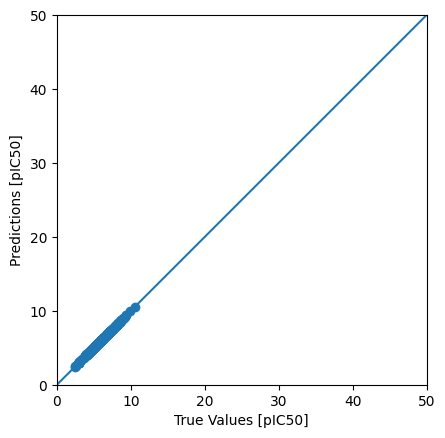

In [ ]:
# Make predictions with best linear regression model on the test set
test_predictions_linear = linear_model_v2.predict(test_features).flatten()

# Scatter plot for linear regression model predictions
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_linear)
plt.xlabel('True Values [pIC50]')
plt.ylabel('Predictions [pIC50]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save the plot as a PDF file
plt.savefig('plot_of_best_linear_model.pdf')

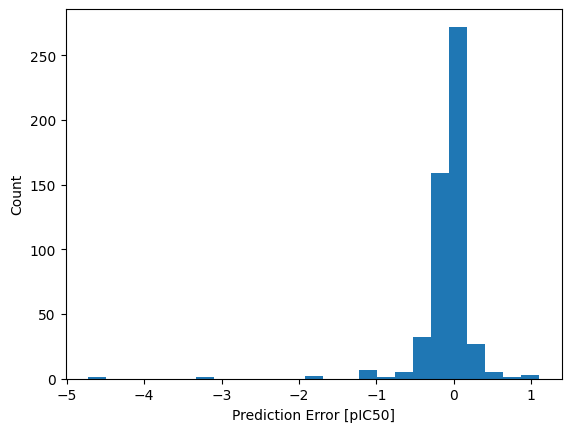

In [ ]:
# Histogram of prediction errors for DNN model
error_dnn = test_predictions_dnn - test_labels
plt.hist(error_dnn, bins=25)
plt.xlabel('Prediction Error [pIC50]')
_ = plt.ylabel('Count')

# Save the plot as a PDF file
plt.savefig('error_plot_of_best_dnn_model.pdf')

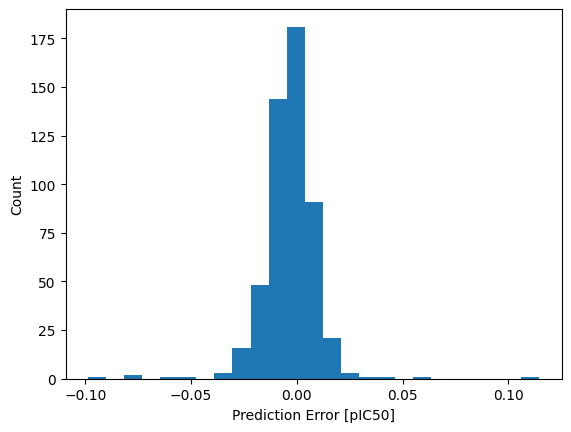

In [ ]:
# Histogram of prediction errors for the best linear model
error_linear = test_predictions_linear - test_labels
plt.hist(error_linear, bins=25)
plt.xlabel('Prediction Error [pIC50]')
_ = plt.ylabel('Count')

# Save the plot as a PDF file
plt.savefig('error_plot_of_best_linear_model.pdf')

In [ ]:
# Print the summary for linear_model_scaled
linear_model_v1.summary()

# Print the summary for linear_model_lr
linear_model_v2.summary()

# Print the summary for dnn_model_v2
dnn_model_v1.summary()

# Print the summary for dnn_model_v2
dnn_model_v2.summary()

# Print the summary for dnn_model_v3
#dnn_model_v3.summary()

# Print the summary for dnn_model_bn
#dnn_model_bn.summary()

# Print the summary for dnn_model_dropout
#dnn_model_dropout.summary()

# Print the summary for dnn_model_bn_dropout
#dnn_model_bn_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 883       
                                                                 
Total params: 883 (3.45 KB)
Trainable params: 883 (3.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 883       
                                                                 
Total params: 883 (3.45 KB)
Trainable params: 883 (3.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)     

In [ ]:
import io

# Function to capture summary as a string
def capture_summary(model):
    summary_str = io.StringIO()
    model.summary(print_fn=lambda x: summary_str.write(x + '\n'))
    summary_str.seek(0)
    return summary_str.read()

# Capture summaries
linear_model_v1_summary = capture_summary(linear_model_v1)
linear_model_v2_summary = capture_summary(linear_model_v2)
dnn_model_v1_summary = capture_summary(dnn_model_v1)
dnn_model_v2_summary = capture_summary(dnn_model_v2)
#dnn_model_v3_summary = capture_summary(dnn_model_v3)
#dnn_model_bn_summary = capture_summary(dnn_model_bn)
#dnn_model_dropout_summary = capture_summary(dnn_model_dropout)
#dnn_model_bn_dropout_summary = capture_summary(dnn_model_bn_dropout)

# Save summaries into a DataFrame
data = {
    "Model": ["linear_model_scaled", "linear_model_lr", "dnn_model_v1", "dnn_model_v2"], #"dnn_model_bn", "dnn_model_dropout", "dnn_model_v3", "dnn_model_bn_dropout"],
    "Summary": [linear_model_v1_summary, linear_model_v2_summary, dnn_model_v1_summary, dnn_model_v2_summary] #dnn_model_v3_summary, dnn_model_bn_summary, dnn_model_dropout_summary, dnn_model_bn_dropout_summary]
}

df = pd.DataFrame(data)

# Save DataFrame to Excel
df.to_excel("models_summary.xlsx", index=True)

In [ ]:
from tabulate import tabulate

# Function to get the number of trainable parameters from model summary
def get_num_parameters(model):
    return sum([int(np.prod(p.shape)) for p in model.trainable_weights])

# Create a table
table = [["linear_model_v1", get_num_parameters(linear_model_v1)],
         ["linear_model_v2", get_num_parameters(linear_model_v2)],
         ["dnn_model_v1", get_num_parameters(dnn_model_v1)],
         ["dnn_model_v2", get_num_parameters(dnn_model_v2)]
         #["dnn_model_v3", get_num_parameters(dnn_model_v3)],
         #["dnn_model_bn", get_num_parameters(dnn_model_bn)],
         #["dnn_model_dropout", get_num_parameters(dnn_model_dropout)],
         #["dnn_model_bn_dropout", get_num_parameters(dnn_model_bn_dropout)]
         ]

# Print the table
headers = ["Model", "Number of Trainable Parameters"]
print(tabulate(table, headers=headers, tablefmt="grid"))

# Save as PDF
with open('table_summary.pdf', 'w') as f:
    f.write(tabulate(table, headers=headers, tablefmt="grid"))

# Save as CSV
pd.DataFrame(table, columns=headers).to_csv('table_summary.csv', index=False)

# Save as Excel
pd.DataFrame(table, columns=headers).to_excel('table_summary.xlsx', index=False)

+-----------------+----------------------------------+
| Model           |   Number of Trainable Parameters |
+=================+==================================+
| linear_model_v1 |                              883 |
+-----------------+----------------------------------+
| linear_model_v2 |                              883 |
+-----------------+----------------------------------+
| dnn_model_v1    |                            60737 |
+-----------------+----------------------------------+
| dnn_model_v2    |                            60737 |
+-----------------+----------------------------------+


In [ ]:
! zip -r results.zip . -i *.csv *.pdf *xlsx

  adding: error_plot_of_best_dnn_model.pdf (deflated 34%)
  adding: loss_plot_dnn_v1.pdf (deflated 39%)
  adding: table_summary.pdf (deflated 80%)
  adding: table_summary.csv (deflated 35%)
  adding: error_plot_of_best_linear_model.pdf (deflated 35%)
  adding: results.csv (deflated 40%)
  adding: table_summary.xlsx (deflated 11%)
  adding: loss_plot_linear_regression_v2.pdf (deflated 49%)
  adding: results.xlsx (deflated 11%)
  adding: models_summary.xlsx (deflated 10%)
  adding: plot_of_best_dnn_model.pdf (deflated 22%)
  adding: results.pdf (deflated 31%)
  adding: loss_plot_dnn_v2.pdf (deflated 39%)
  adding: loss_plot_linear_regression_v1.pdf (deflated 49%)
  adding: Alkaline phosphatase tissue non specific_06_bioactivity_data_3class_pIC50_pubchem_fp.csv (deflated 95%)
  adding: plot_of_best_linear_model.pdf (deflated 22%)
